In [87]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pypokerengine.api.game import setup_config, start_poker
from pypokerengine.players import BasePokerPlayer

In [10]:
class FishPlayer(BasePokerPlayer):
    
    def declare_action(self, valid_actions, hole_card, round_state):
        call_action_info = valid_actions[1]
#         print(valid_actions)
        action, amount = call_action_info["action"], call_action_info["amount"]
        return action, amount

    def receive_game_start_message(self, game_info):
        pass
    
    def receive_round_start_message(self, round_count, hole_card, seats):
        pass
    
    def receive_street_start_message(self, street, round_state):
        pass
    
    def receive_game_update_message(self, action, round_state):
        pass
    
    def receive_round_result_message(self, winners, hand_info, round_state):
        pass
    
config = setup_config(max_round=5, initial_stack=100, small_blind_amount=5)
config.register_player(name="p1", algorithm=FishPlayer())
config.register_player(name="p2", algorithm=FishPlayer())
game_result = start_poker(config, verbose=1)
game_result

Started the round 1
Street "preflop" started. (community card = [])
"p2" declared "call:10"
"p1" declared "call:10"
Street "flop" started. (community card = ['SJ', 'CT', 'SQ'])
"p2" declared "call:0"
"p1" declared "call:0"
Street "turn" started. (community card = ['SJ', 'CT', 'SQ', 'D7'])
"p2" declared "call:0"
"p1" declared "call:0"
Street "river" started. (community card = ['SJ', 'CT', 'SQ', 'D7', 'HQ'])
"p2" declared "call:0"
"p1" declared "call:0"
"['p2']" won the round 1 (stack = {'p1': 90, 'p2': 110})
Started the round 2
Street "preflop" started. (community card = [])
"p1" declared "call:10"
"p2" declared "call:10"
Street "flop" started. (community card = ['D6', 'HQ', 'H2'])
"p1" declared "call:0"
"p2" declared "call:0"
Street "turn" started. (community card = ['D6', 'HQ', 'H2', 'HJ'])
"p1" declared "call:0"
"p2" declared "call:0"
Street "river" started. (community card = ['D6', 'HQ', 'H2', 'HJ', 'D7'])
"p1" declared "call:0"
"p2" declared "call:0"
"['p2']" won the round 2 (stack

{'rule': {'initial_stack': 100,
  'max_round': 5,
  'small_blind_amount': 5,
  'ante': 0,
  'blind_structure': {}},
 'players': [{'name': 'p1',
   'uuid': 'lnzngavgpdkaktedjkslfu',
   'stack': 90,
   'state': 'participating'},
  {'name': 'p2',
   'uuid': 'uhgnlpeuyrkopguxtxawfi',
   'stack': 110,
   'state': 'participating'}]}

In [41]:
suites = ('H', 'C', 'S', 'D')
faces = [x for x in range(2,10)] + ['T', 'J', 'Q', 'K', 'A']

encoder = {}
i = 0

for s in suites:
    for f in faces:
        encoder[f'{s}{f}'] = i
        i += 1

len(encoder)

52

In [157]:
def create_model():
    hole_cards = tf.keras.Input(shape=(2,52,), name='hole_cards')
    community_cards = tf.keras.Input(shape=(5,52,), name='community_cards')
    stacks_history = tf.keras.Input(shape=(32,2,), name='stacks_history')
    
    cards = tf.keras.layers.concatenate([hole_cards, community_cards], axis=1)
    cards = tf.keras.layers.Flatten()(cards)
    stacks = tf.keras.layers.LSTM(32)(stacks_history)
    
    x = tf.keras.layers.concatenate([cards, stacks])
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    
    action = tf.keras.layers.Dense(3, activation='softmax', name='action')(x)
#     amount = tf.keras.layers.Dense(1, activation='sigmoid', name='amount')(x)
    
    model = tf.keras.Model(
        inputs=[hole_cards, community_cards, stacks_history],
        outputs=action
    )
    
    return model

testmodel = create_model()
testmodel.summary()

hole = ['HA', 'S4']
community = ['ST', 'HJ', 'HQ', 'HK', 'S9']

hole = [encoder[x] for x in hole]
community = [encoder[x] for x in community]

hole = tf.one_hot(hole, 52)
hole = tf.expand_dims(hole, axis=0)

community = tf.one_hot(community, 52)
community = tf.expand_dims(community, axis=0)

stacks = np.random.randint(10, 100, (32,2))
stacks = np.expand_dims(stacks, axis=0)

action = testmodel.predict([hole, community, stacks])
print('action: ', action)
# print('amount: ', amount)

Model: "functional_81"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hole_cards (InputLayer)         [(None, 2, 52)]      0                                            
__________________________________________________________________________________________________
community_cards (InputLayer)    [(None, 5, 52)]      0                                            
__________________________________________________________________________________________________
concatenate_80 (Concatenate)    (None, 7, 52)        0           hole_cards[0][0]                 
                                                                 community_cards[0][0]            
__________________________________________________________________________________________________
stacks_history (InputLayer)     [(None, 32, 2)]      0                                

In [158]:
# game parameters
INITIAL_STACK = 1000

In [159]:
class ThienPlayer(BasePokerPlayer):
    def __init__(self, name, model):
        self.name = name
        self.model = model
        self.stacks_history = np.ones((32,2))*INITIAL_STACK
        self.state_history = []
        self.action_history = []
        self.payoff_history = []
    
    def declare_action(self, valid_actions, hole_card, round_state):
        round_count = round_state['round_count'] % 32
        street = round_state['street']
        if street == 'preflop':
            return valid_actions[1]['action'], valid_actions[1]['amount']
        
        hole = [encoder[x] for x in hole_card]
        community = [encoder[x] for x in round_state['community_card']]
        community += [-1] * (5-len(community))
        
        hole = tf.one_hot(hole, 52)
        hole = tf.expand_dims(hole, axis=0)

        community = tf.one_hot(community, 52)
        community = tf.expand_dims(community, axis=0)
            
        for x in round_state['seats']:
            if x['name'] == self.name:
                self.stacks_history[round_count, 0] = x['stack']
                self.payoff_history.append(x['stack'] - self.stacks_history[(round_count-1+32)%32, 0]) 
            else:
                self.stacks_history[round_count, 1] = x['stack']
        
        stacks_history = np.vstack([self.stacks_history[round_count:], self.stacks_history[:round_count]])
        stacks_history = np.expand_dims(stacks_history, axis=0)
        stacks_history = tf.convert_to_tensor(stacks_history)
        
        state = [hole, community, stacks_history]
        self.state_history.append(state)
        
        action = self.model.predict(state)[0]
        
        action = np.random.choice(3, p=action)
        self.action_history.append(action)
        
        if action < 2:
            amount = valid_actions[action]['amount']
        else:
            amount = valid_actions[action]['amount']['min']
        
        return valid_actions[action]['action'], amount

    def receive_game_start_message(self, game_info):
        pass
    
    def receive_round_start_message(self, round_count, hole_card, seats):
        pass
    
    def receive_street_start_message(self, street, round_state):
        pass
    
    def receive_game_update_message(self, action, round_state):
        pass
    
    def receive_round_result_message(self, winners, hand_info, round_state):
        pass

In [160]:
model = create_model()
player1 = ThienPlayer('p1', model)
player2 = ThienPlayer('p2', model)

config = setup_config(max_round=100, initial_stack=INITIAL_STACK, small_blind_amount=5)
config.register_player(name="p1", algorithm=player1)
config.register_player(name="p2", algorithm=player2)
game_result = start_poker(config, verbose=0)
game_result

{'rule': {'initial_stack': 1000,
  'max_round': 100,
  'small_blind_amount': 5,
  'ante': 0,
  'blind_structure': {}},
 'players': [{'name': 'p1',
   'uuid': 'ofpqfoaqflrhuxuogktxys',
   'stack': 750,
   'state': 'participating'},
  {'name': 'p2',
   'uuid': 'jlazbvgnymlcuhpseqkavx',
   'stack': 1250,
   'state': 'participating'}]}

In [161]:
print(player1.payoff_history)
print(player2.payoff_history)

[-10.0, -10.0, -20.0, 30.0, 20.0, 10.0, -10.0, -10.0, -10.0, -10.0, -20.0, -20.0, -40.0, -10.0, 20.0, -30.0, 10.0, 10.0, -10.0, 10.0, 0.0, -10.0, 30.0, 20.0, 10.0, 10.0, -10.0, 20.0, 10.0, -10.0, -20.0, 40.0, 50.0, -10.0, -20.0, 40.0, 30.0, 20.0, 10.0, 10.0, -10.0, -30.0, -40.0, 80.0, 70.0, 50.0, 40.0, 40.0, -10.0, -20.0, -30.0, -10.0, -20.0, -20.0, -10.0, -10.0, 0.0, 10.0, 10.0, 0.0, -10.0, -20.0, -30.0, 60.0, 60.0, 40.0, 30.0, -10.0, -20.0, -10.0, -10.0, -10.0, -10.0, 10.0, -30.0, -20.0, -10.0, -10.0, -10.0, -20.0, -30.0, 60.0, 60.0, 50.0, -40.0, -40.0, -40.0, -40.0, -10.0, -10.0, -10.0, -20.0, -20.0, -20.0, 10.0, 0.0, -10.0, -10.0, 30.0, 30.0, -80.0, -10.0, -10.0, -20.0, 40.0, 10.0, 10.0, 0.0, 0.0, -10.0, -10.0, -10.0, -20.0, -30.0, -30.0, -60.0, -10.0, -30.0, -40.0, -10.0, 10.0, 10.0, 0.0, 40.0, 30.0, 20.0, 10.0, 0.0, -20.0, -110.0, -10.0, -10.0, 30.0, -100.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -160.0, -170.0, -180.0, -10.0, -10.0, -10.0, -130.0, -110.0, -10.0, -10.0, -10.0,

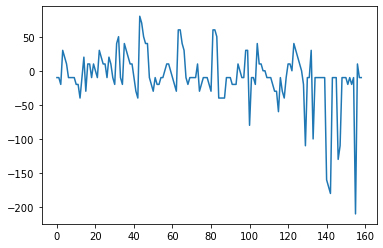

In [162]:
n = len(player1.payoff_history)
plt.plot(np.arange(n), player1.payoff_history)

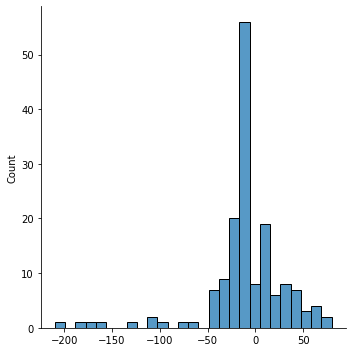

In [163]:
sns.displot(player1.payoff_history)

In [164]:
hole = []
community = []
stack = []
for state in player1.state_history:
    hole.append(state[0])
    community.append(state[1])
    stack.append(state[2])
    
tf.stack(hole, axis=1)[0]

<tf.Tensor: shape=(159, 2, 52), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [165]:
def select_train_data(states, actions, payoffs, percentile=70):
    hole = []
    community = []
    stack = []
    
    for state in states:
        hole.append(state[0])
        community.append(state[1])
        stack.append(state[2])
    
    hole = tf.stack(hole, axis=1)[0]
    community = tf.stack(community, axis=1)[0]
    stack = tf.stack(stack, axis=1)[0]
        
    actions = np.array(actions)
    payoffs = np.array(payoffs)
    
    threshold = np.percentile(payoffs, q=percentile)
    
    select = (payoffs >= threshold)
    
    return hole[select], community[select], stack[select], actions[select]

train_hole, train_community, train_stack, train_actions = select_train_data(player1.state_history, player1.action_history, player1.payoff_history)
train_hole

<tf.Tensor: shape=(49, 2, 52), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [166]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['acc']
)
model.fit([train_hole, train_community, train_stack], train_actions, epochs=10)

Epoch 1/10
2/2 [==============================] - 0s 6ms/step - loss: 1.0761 - acc: 0.4694
Epoch 2/10
2/2 [==============================] - 0s 7ms/step - loss: 1.0365 - acc: 0.4898
Epoch 3/10
2/2 [==============================] - 0s 6ms/step - loss: 1.0084 - acc: 0.5714
Epoch 4/10
2/2 [==============================] - 0s 6ms/step - loss: 0.9831 - acc: 0.5918
Epoch 5/10
2/2 [==============================] - 0s 6ms/step - loss: 0.9608 - acc: 0.5918
Epoch 6/10
2/2 [==============================] - 0s 4ms/step - loss: 0.9404 - acc: 0.6327
Epoch 7/10
2/2 [==============================] - 0s 5ms/step - loss: 0.9202 - acc: 0.6531
Epoch 8/10
2/2 [==============================] - 0s 5ms/step - loss: 0.8974 - acc: 0.6531
Epoch 9/10
2/2 [==============================] - 0s 5ms/step - loss: 0.8742 - acc: 0.6735
Epoch 10/10
2/2 [==============================] - 0s 4ms/step - loss: 0.8504 - acc: 0.6939


In [178]:
def test_players(player1, player2, max_round=100):
    config = setup_config(max_round=max_round, initial_stack=INITIAL_STACK, small_blind_amount=5)
    config.register_player(name="p1", algorithm=player1)
    config.register_player(name="p2", algorithm=player2)
    game_result = start_poker(config, verbose=0)
    return game_result

player_trained = ThienPlayer('p1', model)
test_players(player_trained, FishPlayer())

{'rule': {'initial_stack': 1000,
  'max_round': 100,
  'small_blind_amount': 5,
  'ante': 0,
  'blind_structure': {}},
 'players': [{'name': 'p1',
   'uuid': 'zbipdrigtriypwphzobcyb',
   'stack': 230,
   'state': 'participating'},
  {'name': 'p2',
   'uuid': 'grbovejpwinkiznvruhenq',
   'stack': 1770,
   'state': 'participating'}]}

In [168]:
poker_model = create_model()
poker_model.summary()

Model: "functional_85"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hole_cards (InputLayer)         [(None, 2, 52)]      0                                            
__________________________________________________________________________________________________
community_cards (InputLayer)    [(None, 5, 52)]      0                                            
__________________________________________________________________________________________________
concatenate_84 (Concatenate)    (None, 7, 52)        0           hole_cards[0][0]                 
                                                                 community_cards[0][0]            
__________________________________________________________________________________________________
stacks_history (InputLayer)     [(None, 32, 2)]      0                                

In [170]:
def generate_game_session(model, max_round=100):
    player1 = ThienPlayer('p1', model)
    player2 = ThienPlayer('p2', model)
    
    config = setup_config(max_round=max_round, initial_stack=INITIAL_STACK, small_blind_amount=5)
    config.register_player(name="p1", algorithm=player1)
    config.register_player(name="p2", algorithm=player2)
    game_result = start_poker(config, verbose=0)
    
    states = player1.state_history + player2.state_history
    actions = player1.action_history + player2.action_history
    payoffs = player1.payoff_history + player2.payoff_history
    
    return states, actions, payoffs

states, actions, payoffs = generate_game_session(poker_model)

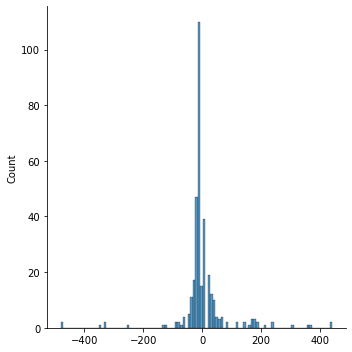

In [171]:
sns.displot(payoffs)

In [181]:
def train_model(model, epochs=100):
    print('Epoch \t ThienPlayer \t FishPlayer')
    
    for i in range(epochs):
        states, actions, payoffs = generate_game_session(model)
        train_hole, train_community, train_stack, train_actions = select_train_data(states, actions, payoffs)
        
        model.fit(
            [train_hole, train_community, train_stack], 
            train_actions, 
            epochs=1,
            batch_size=128,
            verbose=0
        )
        
        player = ThienPlayer('p1', model)
        game_result = test_players(player, FishPlayer())
        
        print(f"{i+1} \t {game_result['players'][0]['stack']} \t\t {game_result['players'][1]['stack']}")

poker_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['acc']
)

train_model(poker_model, epochs=5)

Epoch 	 ThienPlayer 	 FishPlayer
2/2 [==============================] - 0s 5ms/step - loss: 0.9853 - acc: 0.5901
1 	 810 	 1190
2/2 [==============================] - 0s 4ms/step - loss: 0.9705 - acc: 0.5732
2 	 780 	 1220
2/2 [==============================] - 0s 5ms/step - loss: 1.0535 - acc: 0.4839
3 	 370 	 1630
2/2 [==============================] - 0s 4ms/step - loss: 1.0010 - acc: 0.5273
4 	 190 	 1810
2/2 [==============================] - 0s 5ms/step - loss: 1.0469 - acc: 0.4873
5 	 660 	 1340


In [175]:
player1 = ThienPlayer('p1', model)

config = setup_config(max_round=100, initial_stack=INITIAL_STACK, small_blind_amount=5)
config.register_player(name="p1", algorithm=player1)
config.register_player(name="p2", algorithm=FishPlayer())
game_result = start_poker(config, verbose=0)
game_result

{'rule': {'initial_stack': 1000,
  'max_round': 100,
  'small_blind_amount': 5,
  'ante': 0,
  'blind_structure': {}},
 'players': [{'name': 'p1',
   'uuid': 'fdrfscjyjfjaywctcoedcc',
   'stack': 90,
   'state': 'participating'},
  {'name': 'p2',
   'uuid': 'bdiaemguesxszzuzdbfvcd',
   'stack': 1910,
   'state': 'participating'}]}